In [1]:
from data.dataset import GWF_HP_Dataset
from data.dataloader import DataLoader
from data.transforms import NormalizeTransform, ComposeTransform, ReduceTo2DTransform, PowerOfTwoTransform, ToTensorTransform
from visualization.visualize_data import plot_datapoint
from data.utils_save import save_pickle
from networks.unet_leiterrl import TurbNetG, UNet, weights_init

import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import h5py
from tqdm.auto import tqdm
from torchvision.utils import make_grid

COLOR = 'white'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
# TODO not necessary to cut of edges - exponential behaviour at edges ?! fix it otherwise!
#transforms = ComposeTransform([NormalizeTransform(), CutOffEdgesTransform()])

# DATASET = GWF_HP_Dataset(dataset_name ="dataset_HDF5_testtest", transform = NormalizeTransform(), 
#                  input_vars=["Liquid Y-Velocity [m_per_y]", "Liquid Z-Velocity [m_per_y]", 
#                  "Liquid_Pressure [Pa]", "Material_ID", "Temperature [C]"],
#                  output_vars=["Liquid_Pressure [Pa]", "Temperature [C]"])
# DATALOADER = DataLoader(DATASET, batch_size=2, shuffle=True, drop_last=False)
# 
# print(f"Dataset size: {len(DATASET)}")
# print(f"Dataloader size: {len(DATALOADER)}")
# 
# save_pickle({"dataset": DATASET, "dataloader" : DATALOADER}, "dataset_HDF5_testtest_and_dataloader.p")
# 
# DATASET[0]['x'][0,:,:,:].shape
# plot_datapoint(DATASET, run_id=1, view="side_hp")

# TODO Data Augmentation

In [4]:
# TODO:  data augmentation

# Splitting Data

In [5]:
# # split dataset into train, val, test
# datasets = {}
# for mode in ['train', 'val', 'test']:
#     temp_dataset = GWF_HP_Dataset(
#         dataset_name ="dataset_HDF5_testtest", transform = NormalizeTransform(), 
#         input_vars=["Liquid Y-Velocity [m_per_y]", "Liquid Z-Velocity [m_per_y]", 
#         "Liquid_Pressure [Pa]", "Material_ID", "Temperature [C]"],
#         output_vars=["Liquid_Pressure [Pa]", "Temperature [C]"],
#         mode=mode, split={'train': 0.6, 'val': 0.2, 'test': 0.2}
#     )
#     datasets[mode] = temp_dataset
# 
# # Create a dataloader for each split.
# dataloaders = {}
# for mode in ['train', 'val', 'test']:
#     temp_dataloader = DataLoader(
#         dataset=datasets[mode],
#         batch_size=2,
#         shuffle=True,
#         drop_last=False,
#     )
#     dataloaders[mode] = temp_dataloader

## test splitting data

In [6]:
# print(datasets["train"].runs)
# print(datasets["train"][0].keys())
# print(len(dataloaders["train"]))
# 
# for batch in dataloaders["train"]:
#     print(batch['x'].shape)
#     print(batch['y'].shape)
#     break

# simplest test NN (linear)

# test TurbNetG (from Rapha, from somebody else) 2D testcase on my data

In [7]:
from torch.optim import Adam
from torch.nn import MSELoss
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

In [196]:
# split dataset into train, val, test
def init_data(reduce_to_2D = True, overfit = False, normalize=True, dataset_name="dataset_HDF5_testtest", batch_size=100):
    
    datasets = {}
    transforms_list = [ToTensorTransform(), PowerOfTwoTransform(oriented="left")]
    if normalize:
        transforms_list.append(NormalizeTransform())
    if reduce_to_2D:
        transforms_list.append(ReduceTo2DTransform())

    transforms = ComposeTransform(transforms_list)
    split = {'train': 0.6, 'val': 0.2, 'test': 0.2} if not overfit else {'train': 0.2, 'val': 0.2, 'test': 0.6}
    
    for mode in ['train', 'val', 'test']:
        temp_dataset = GWF_HP_Dataset(
            dataset_name =dataset_name, transform = transforms,
            input_vars=["Liquid Y-Velocity [m_per_y]", "Liquid Z-Velocity [m_per_y]",  #"Liquid X-Velocity [m_per_y]",
            "Liquid_Pressure [Pa]", "Material_ID", "Temperature [C]"],
            output_vars=["Temperature [C]"], #. "Liquid_Pressure [Pa]"
            mode=mode, split=split
        )
        datasets[mode] = temp_dataset


    # Create a dataloader for each split.
    dataloaders = {}
    for mode in ['train', 'val', 'test']:
        temp_dataloader = DataLoader(
            dataset=datasets[mode],
            batch_size=batch_size,
            shuffle=True,
            drop_last=False,
        )
        dataloaders[mode] = temp_dataloader

    # # Assert if data is not 2D
    # def assertion_error_2d(datasets):
    #     for dataset in datasets["train"]:
    #         shape_data = len(dataset['x'].shape)
    #         break
    #     assert shape_data == 3, "Data is not 2D"
    # 
    # assertion_error_2d(datasets)

    return datasets, dataloaders

In [199]:
def train_model(model, dataloaders, loss_fn, n_epochs, lr):
    optimizer = Adam(model.parameters(), lr=lr) 
    writer = SummaryWriter()
    loss_hist = []
    
    model.apply(weights_init)
    epochs = tqdm(range(n_epochs), desc = "epochs")
    for epoch in epochs:
        for batch_idx, data_point in enumerate(dataloaders["train"]):
            # datasets["train"] contains 3 data points
            # TODO in welchem Format das input und target angegeben werden muss
            x = data_point["x"].float()
            y = data_point["y"].float()

            model.zero_grad()
            optimizer.zero_grad()

            y_out = model(x) # dimensions: batch-datapoint_id, channel, x, y
            mse_loss = loss_fn(y_out, y)
            loss = mse_loss
            
            loss.backward()
            optimizer.step()
            epochs.set_postfix_str(f"loss: {loss.item():.4f}")

            loss_hist.append(loss.item())
            writer.add_scalar("loss", loss.item(), epoch*len(dataloaders["train"])+batch_idx)
            # writer.add_image("x_0", x[0,0,:,:], dataformats="WH")
            # writer.add_image("x_1", x[0,1,:,:], dataformats="WH")
            # writer.add_image("x_2", x[0,2,:,:], dataformats="WH")
            # writer.add_image("x_3", x[0,3,:,:], dataformats="WH")
            # writer.add_image("x_4", x[0,4,:,:], dataformats="WH")
            # writer.add_image("y_0", y[0,0,:,:], dataformats="WH")
            # #writer.add_image("y_1", y[0,1,:,:], dataformats="WH")
            writer.add_image("y_out_0", y_out[0,0,:,:], dataformats="WH", global_step=epoch*len(dataloaders["train"])+batch_idx)
            #writer.add_image("y_out_1", y_out[0,1,:,:], dataformats="WH")

    #writer.add_graph(model, x)
    print('Finished Training')

In [212]:
# parameters of model and training
loss_fn = MSELoss()
n_epochs = 60000
lr=0.0004 #0.0004

#model = TurbNetG(channelExponent=4, in_channels=4, out_channels=2)
unet_model = UNet(in_channels=5, out_channels=1).float()
# TODO too many in channels for unet?
fc_model = nn.Sequential(nn.Flatten(), nn.Linear(5*128*16, 1*128*16), nn.Unflatten(dim=1,unflattened_size=[1,128,16])).float()
# model.to(device)

datasets_2D, dataloaders_2D = init_data(reduce_to_2D=True, overfit=True)

# running the training
train_model(unet_model, dataloaders_2D, loss_fn, n_epochs, lr)

Directory of currently used dataset is: /home/pelzerja/Development/simulation_groundtruth_pflotran/Phd_simulation_groundtruth/approach2_dataset_generation_simplified/dataset_HDF5_testtest
Directory of currently used dataset is: /home/pelzerja/Development/simulation_groundtruth_pflotran/Phd_simulation_groundtruth/approach2_dataset_generation_simplified/dataset_HDF5_testtest
Directory of currently used dataset is: /home/pelzerja/Development/simulation_groundtruth_pflotran/Phd_simulation_groundtruth/approach2_dataset_generation_simplified/dataset_HDF5_testtest


epochs: 100%|██████████| 60000/60000 [1:25:27<00:00, 11.70it/s, loss: 0.0366]

Finished Training


In [206]:
# print(dataloaders_2D["train"].dataset[0]['x'].shape)

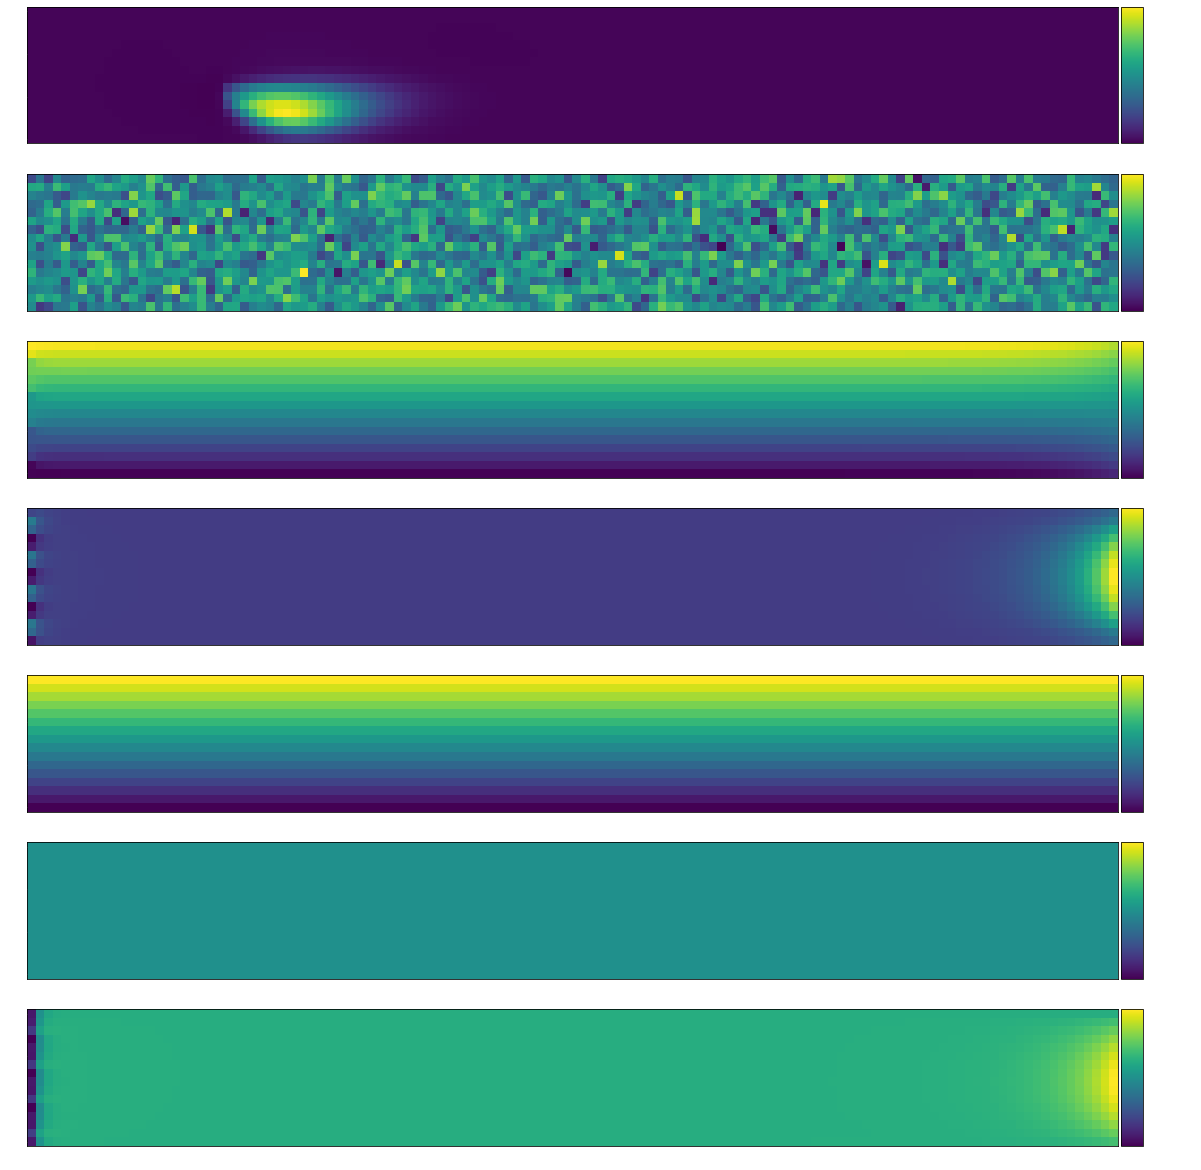

In [213]:
from visualization.visualize_data import aligned_colorbar

writer = SummaryWriter()

def slice_y(y, property):
    property = 0 if property == "temperature" else property #1
    return y.detach().numpy()[0,property,:,:]

def plot_y(data):
    n_subplots = len(data)
    fig, axes = plt.subplots(n_subplots,1,sharex=True,figsize=(20,3*(n_subplots)))
    plt.title("Exemplary Comparison Input Output")
    
    for index, data_point in enumerate(data):
        plt.sca(axes[index])
        plt.imshow(slice_y(data_point["data"], data_point["property"]).T)
        aligned_colorbar(label=data_point["property"])

    

for data_test in dataloaders_2D["train"]:
    x_test = data_test["x"].float()
    y_true_test = data_test["y"].float()
    y_out_test = fc_model(x_test)
    # writer.add_image("y_out_test_0", y_out_test[0,0,:,:], dataformats="WH", global_step=0)
    # writer.add_image("y_true_test_0", y_true_test[0,0,:,:], dataformats="WH", global_step=0)
    # 
    # mse_loss = loss_fn(y_out_test, y_true_test)
    # loss = mse_loss
    # 
    # writer.add_scalar("loss", loss.item(), 0)
    break

def make_dict(data, property):
    dict = {"data" : data, "property" : property}
    return dict

list_to_plot = [
    make_dict(y_true_test, "temperature"),
    make_dict(y_out_test, "temperature"),
    make_dict(x_test, 0),
    make_dict(x_test, 1),
    make_dict(x_test, 2),
    make_dict(x_test, 3),
    make_dict(x_test, 4)
]

plot_y(list_to_plot)


## test visualization and normalization and reverse of data

Directory of currently used dataset is: /home/pelzerja/Development/simulation_groundtruth_pflotran/Phd_simulation_groundtruth/approach2_dataset_generation_simplified/../groundtruth_no_hps/groundtruth_no_hps
Directory of currently used dataset is: /home/pelzerja/Development/simulation_groundtruth_pflotran/Phd_simulation_groundtruth/approach2_dataset_generation_simplified/../groundtruth_no_hps/groundtruth_no_hps
Directory of currently used dataset is: /home/pelzerja/Development/simulation_groundtruth_pflotran/Phd_simulation_groundtruth/approach2_dataset_generation_simplified/../groundtruth_no_hps/groundtruth_no_hps
torch.Size([5, 16, 128, 16])


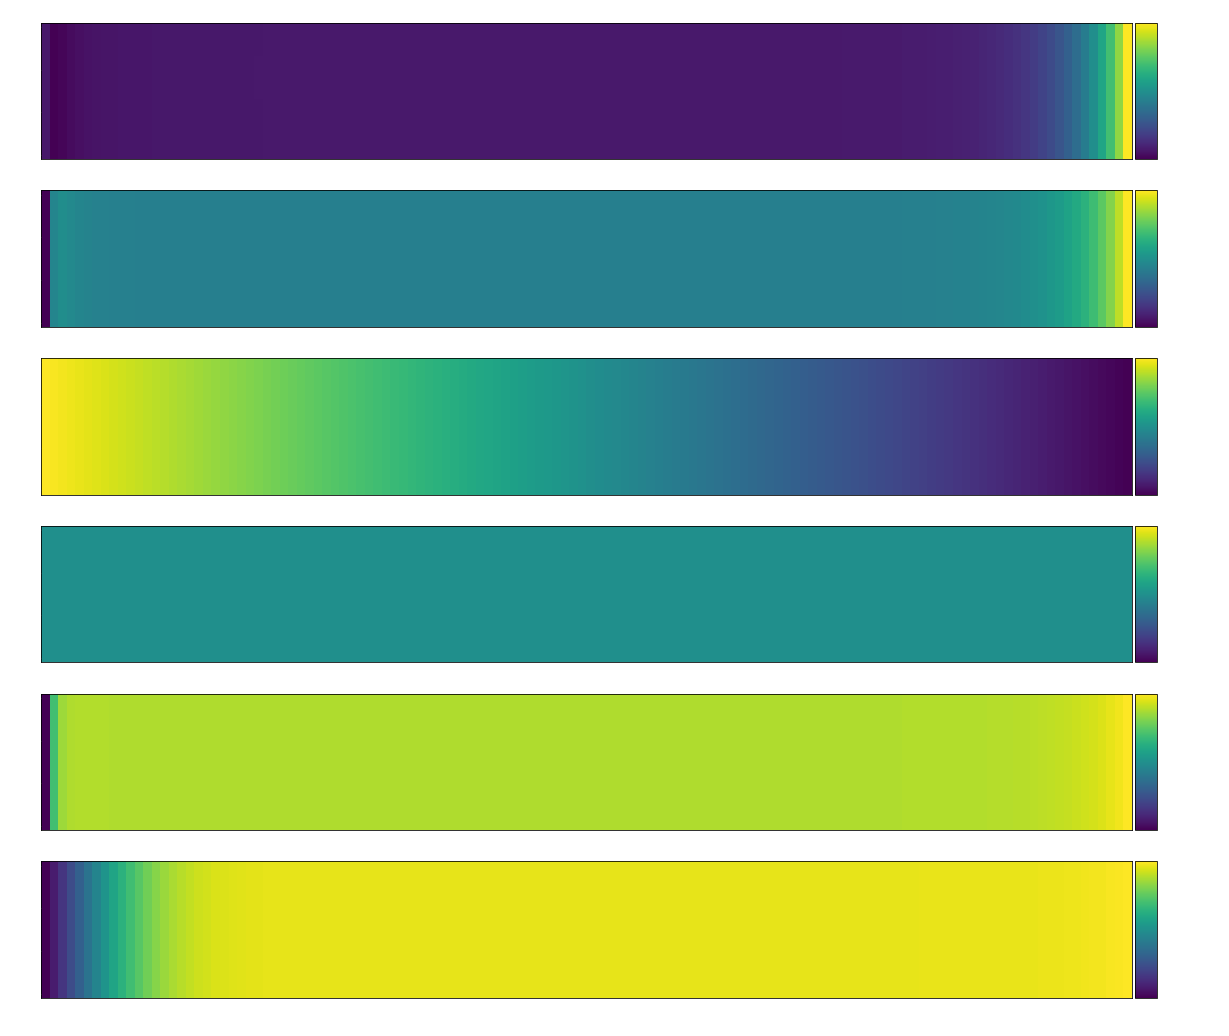

In [93]:
from visualization.visualize_data import plot_data_inner

datasets, dataloaders = init_data(reduce_to_2D=False, overfit=True, dataset_name="../groundtruth_no_hps/groundtruth_no_hps")
tensor_dict = datasets["train"][0]
tensor_reversed_norm = datasets["train"].reverse_transform(0, tensor_dict["x_mean"], tensor_dict["x_std"], tensor_dict["y_mean"], tensor_dict["y_std"])

prop_in = datasets["train"].get_input_properties()
prop_out = datasets["train"].get_output_properties()

print(datasets["train"][0]["x"].shape)

plot_data_inner(tensor_reversed_norm, prop_in, prop_out, view="top", oriented="left")

#plot_datapoint(datasets["train"], run_id=0, view="side_hp", oriented="left")
# plot_datapoint(datasets["train"], run_id=0, view="top_hp")

Directory of currently used dataset is: /home/pelzerja/Development/simulation_groundtruth_pflotran/Phd_simulation_groundtruth/approach2_dataset_generation_simplified/../groundtruth_no_hps/groundtruth_no_hps
Directory of currently used dataset is: /home/pelzerja/Development/simulation_groundtruth_pflotran/Phd_simulation_groundtruth/approach2_dataset_generation_simplified/../groundtruth_no_hps/groundtruth_no_hps
Directory of currently used dataset is: /home/pelzerja/Development/simulation_groundtruth_pflotran/Phd_simulation_groundtruth/approach2_dataset_generation_simplified/../groundtruth_no_hps/groundtruth_no_hps
torch.Size([5, 16, 128, 16])


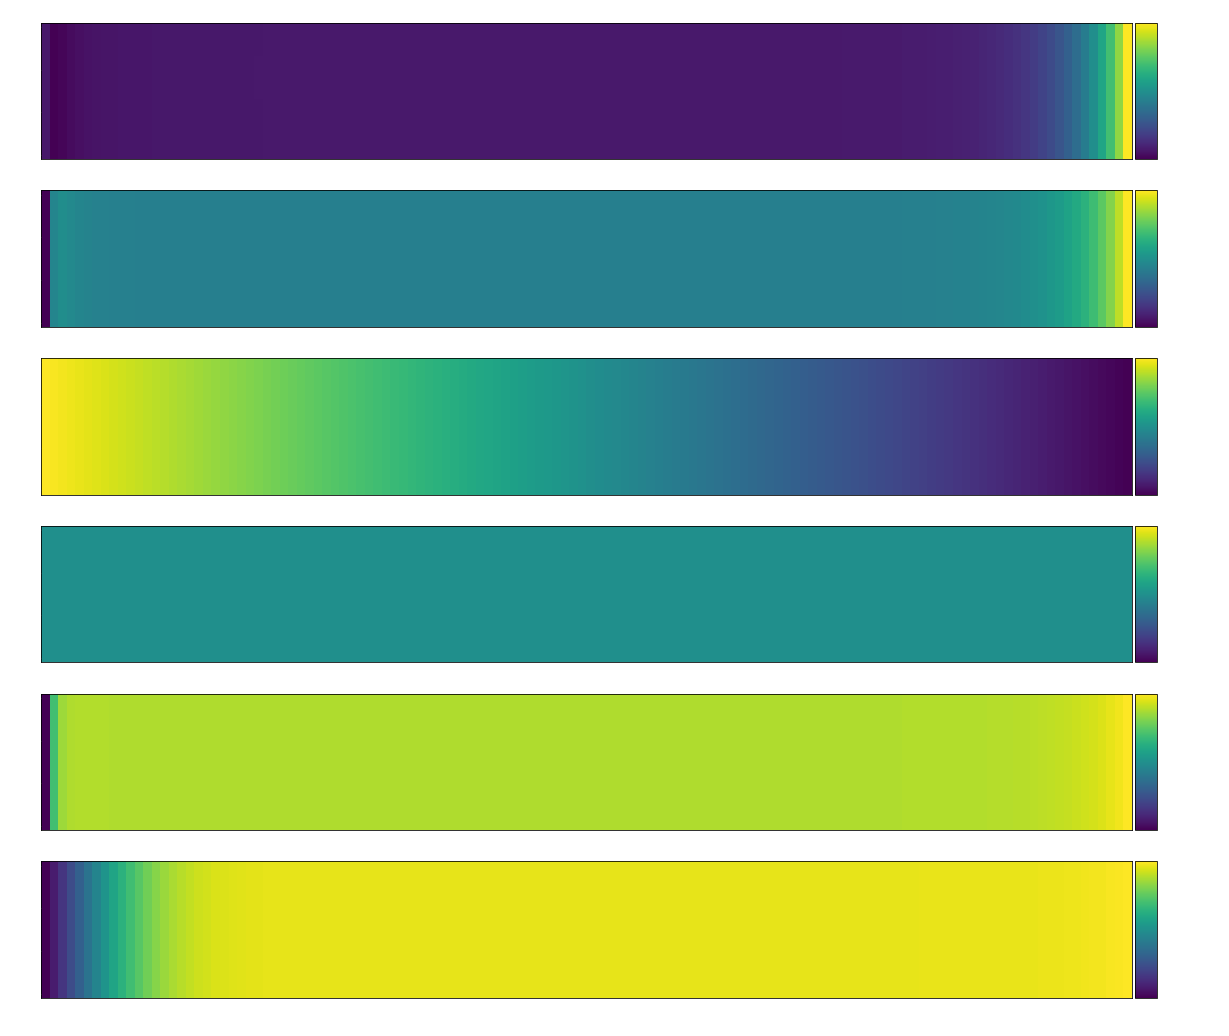

In [95]:
datasets, dataloaders = init_data(reduce_to_2D=False, overfit=True, dataset_name="../groundtruth_no_hps/groundtruth_no_hps")
tensor_dict = datasets["train"][0]
tensor_reversed_norm = datasets["train"].reverse_transform(0, tensor_dict["x_mean"], tensor_dict["x_std"], tensor_dict["y_mean"], tensor_dict["y_std"])

prop_in = datasets["train"].get_input_properties()
prop_out = datasets["train"].get_output_properties()

print(datasets["train"][0]["x"].shape)

plot_data_inner(tensor_reversed_norm, prop_in, prop_out, view="top", oriented="left")
